# Let's Dive into CNNs
## Please read the following paragraph I copy-pasted from ChatGPT:
Welcome back to the exciting world of Convolutional Neural Networks (CNN), building on our previous question which focused on Multilayer Perceptrons (MLP)! As you already know, CNNs are a powerful tool for image and video processing applications. They are designed to recognize patterns and features in visual data, making them a popular choice in computer vision research. One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data, which preserves spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data. MLPs are limited in their ability to process images because they require that the input data be flattened into a one-dimensional vector, which can result in a loss of important spatial information. In contrast, CNNs are designed to handle multi-dimensional data such as images, preserving spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

In this assignment, we will be playing with the CIFAR-10 dataset to explore different CNN models. We will start by training an auto-encoder for CIFAR images. This auto-encoder will allow us to compare different models, including a Multilayer Perceptron (MLP) model, a CNN-MLP mixed model, and finally a CNN-only model. By comparing the performance of these models, we can gain a deeper understanding of the importance of CNN layers in image processing tasks.

Once we've completed our auto-encoder experiments, we will use the encoder from the best-performing model to train a Siamese network. Siamese networks are a type of neural network that can recognize similarity between two images, making them a popular choice for tasks such as image retrieval and face recognition. By training a Siamese network using the CIFAR-10 dataset, we can gain a better understanding of how CNNs can be used in more complex image recognition tasks.

Overall, this assignment will allow us to explore the many different applications of CNNs in image processing tasks. We'll have the opportunity to experiment with different architectures, compare their performance, and gain valuable insights into how CNNs can be used to solve real-world problems.

🫵Pro-tip: Utilize learnings from previous question to better solve problems in this question.

💭Trivia: Yes, I am allowed use ChatGPT!

## Part 0: Initialization
### Step zero: Import Libraries

In [6]:
# code here
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import random
import torchvision.transforms as transforms
import numpy as np
import torch


### Step one: Using a PyTorch Dataset
Load CIFAR-10 dataset from `torchvision.datasets`. Keep batch_size >= 16.

In [7]:
torch.manual_seed(0)
random.seed(0)

In [8]:
# code here
transform = transforms.Compose([
                    transforms.ToTensor(), 
            ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, pin_memory=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


torch.Size([16, 3, 32, 32])
tensor(0.) tensor(1.)
torch.Size([16])


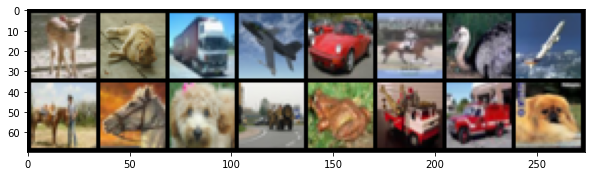

In [9]:
# let's have a look at the dataset
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(torch.min(images), torch.max(images))
print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))

## Part 1: Auto-Encoder
### Step one: Define 3 Models for Auto-Encoder
1. MLP-only model
2. CNN-MLP combination model
3. CNN-only model

In all the models, encoder and decoder should be consisting of $3$ layers each, and the encoder should be giving a flattened representation of size $32$.

Please see that each layer of encoder should decrease or keep equal the output size as compared to input size. Similarly, each layer of decoder should increase or keep equal the output size as compared to input size. 

In [10]:
class AutoEncoder_MLP(nn.Module):
    def __init__(self):
        super(AutoEncoder_MLP, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3072, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 8))
        
        self.decoder = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 3072),
            nn.Sigmoid(),
            nn.Unflatten(1,(3,32,32))
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [12]:
from torchsummary import summary
mlpsumm = AutoEncoder_MLP()
summary(mlpsumm, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 8]                   --
|    └─Flatten: 2-1                      [-1, 3072]                --
|    └─Linear: 2-2                       [-1, 128]                 393,344
|    └─ReLU: 2-3                         [-1, 128]                 --
|    └─Linear: 2-4                       [-1, 32]                  4,128
|    └─ReLU: 2-5                         [-1, 32]                  --
|    └─Linear: 2-6                       [-1, 8]                   264
├─Sequential: 1-2                        [-1, 3, 32, 32]           --
|    └─Linear: 2-7                       [-1, 32]                  288
|    └─ReLU: 2-8                         [-1, 32]                  --
|    └─Linear: 2-9                       [-1, 128]                 4,224
|    └─ReLU: 2-10                        [-1, 128]                 --
|    └─Linear: 2-11                      [-1, 3072]                396,2

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 8]                   --
|    └─Flatten: 2-1                      [-1, 3072]                --
|    └─Linear: 2-2                       [-1, 128]                 393,344
|    └─ReLU: 2-3                         [-1, 128]                 --
|    └─Linear: 2-4                       [-1, 32]                  4,128
|    └─ReLU: 2-5                         [-1, 32]                  --
|    └─Linear: 2-6                       [-1, 8]                   264
├─Sequential: 1-2                        [-1, 3, 32, 32]           --
|    └─Linear: 2-7                       [-1, 32]                  288
|    └─ReLU: 2-8                         [-1, 32]                  --
|    └─Linear: 2-9                       [-1, 128]                 4,224
|    └─ReLU: 2-10                        [-1, 128]                 --
|    └─Linear: 2-11                      [-1, 3072]                396,2

In [14]:
class AutoEncoder_Combo(nn.Module):
    def __init__(self):
        super(AutoEncoder_Combo, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64, 32))
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.Unflatten(-1, (4, 4, 4)),
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [15]:
from torchsummary import summary
mlpcombo = AutoEncoder_Combo()
summary(mlpcombo, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32]                  --
|    └─Conv2d: 2-1                       [-1, 16, 32, 32]          448
|    └─ReLU: 2-2                         [-1, 16, 32, 32]          --
|    └─MaxPool2d: 2-3                    [-1, 16, 16, 16]          --
|    └─Conv2d: 2-4                       [-1, 8, 16, 16]           1,160
|    └─ReLU: 2-5                         [-1, 8, 16, 16]           --
|    └─MaxPool2d: 2-6                    [-1, 8, 8, 8]             --
|    └─Conv2d: 2-7                       [-1, 4, 8, 8]             292
|    └─ReLU: 2-8                         [-1, 4, 8, 8]             --
|    └─MaxPool2d: 2-9                    [-1, 4, 4, 4]             --
|    └─Flatten: 2-10                     [-1, 64]                  --
|    └─Linear: 2-11                      [-1, 32]                  2,080
├─Sequential: 1-2                        [-1, 3, 32, 32]           --
|    └─

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32]                  --
|    └─Conv2d: 2-1                       [-1, 16, 32, 32]          448
|    └─ReLU: 2-2                         [-1, 16, 32, 32]          --
|    └─MaxPool2d: 2-3                    [-1, 16, 16, 16]          --
|    └─Conv2d: 2-4                       [-1, 8, 16, 16]           1,160
|    └─ReLU: 2-5                         [-1, 8, 16, 16]           --
|    └─MaxPool2d: 2-6                    [-1, 8, 8, 8]             --
|    └─Conv2d: 2-7                       [-1, 4, 8, 8]             292
|    └─ReLU: 2-8                         [-1, 4, 8, 8]             --
|    └─MaxPool2d: 2-9                    [-1, 4, 4, 4]             --
|    └─Flatten: 2-10                     [-1, 64]                  --
|    └─Linear: 2-11                      [-1, 32]                  2,080
├─Sequential: 1-2                        [-1, 3, 32, 32]           --
|    └─

In [17]:
class AutoEncoder_CNN(nn.Module):
    def __init__(self):
        super(AutoEncoder_CNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [18]:
from torchsummary import summary
cnn_encoder = AutoEncoder_CNN()
summary(cnn_encoder, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4, 4, 4]             --
|    └─Conv2d: 2-1                       [-1, 16, 32, 32]          448
|    └─ReLU: 2-2                         [-1, 16, 32, 32]          --
|    └─MaxPool2d: 2-3                    [-1, 16, 16, 16]          --
|    └─Conv2d: 2-4                       [-1, 8, 16, 16]           1,160
|    └─ReLU: 2-5                         [-1, 8, 16, 16]           --
|    └─MaxPool2d: 2-6                    [-1, 8, 8, 8]             --
|    └─Conv2d: 2-7                       [-1, 4, 8, 8]             292
|    └─ReLU: 2-8                         [-1, 4, 8, 8]             --
|    └─MaxPool2d: 2-9                    [-1, 4, 4, 4]             --
├─Sequential: 1-2                        [-1, 3, 32, 32]           --
|    └─ConvTranspose2d: 2-10             [-1, 8, 8, 8]             296
|    └─ReLU: 2-11                        [-1, 8, 8, 8]             --
|    └─Co

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4, 4, 4]             --
|    └─Conv2d: 2-1                       [-1, 16, 32, 32]          448
|    └─ReLU: 2-2                         [-1, 16, 32, 32]          --
|    └─MaxPool2d: 2-3                    [-1, 16, 16, 16]          --
|    └─Conv2d: 2-4                       [-1, 8, 16, 16]           1,160
|    └─ReLU: 2-5                         [-1, 8, 16, 16]           --
|    └─MaxPool2d: 2-6                    [-1, 8, 8, 8]             --
|    └─Conv2d: 2-7                       [-1, 4, 8, 8]             292
|    └─ReLU: 2-8                         [-1, 4, 8, 8]             --
|    └─MaxPool2d: 2-9                    [-1, 4, 4, 4]             --
├─Sequential: 1-2                        [-1, 3, 32, 32]           --
|    └─ConvTranspose2d: 2-10             [-1, 8, 8, 8]             296
|    └─ReLU: 2-11                        [-1, 8, 8, 8]             --
|    └─Co

In [23]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
       
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.Flatten(), 
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (12, 16, 16)), 
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), 
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


### Step two: Using MSELoss, train all the models and analyse results
Make sure you also discuss size, time-taken and any other differences you found. Plot MSELoss for each epoch for all models. Also, tabulate the final MSELosses of all models and plot it vis-a-vis:

1. Model Size
2. Model Parameters
3. Time Taken per epoch 

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

In [25]:
def train_and_test(model, optimizer, epochs):
    
    trainLoss_lis = []
    testLoss_lis = []

    for epcount in range(epochs):
        model.train()
        train_loss = 0
        for i, data in enumerate(trainloader, 0):
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss = train_loss / len(trainloader.dataset)

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data in testloader:
                inputs, _ = data
                inputs = inputs.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                test_loss += loss.item() * inputs.size(0)
        test_loss = test_loss / len(testloader.dataset)
        print(f"Train loss: {train_loss} and Test loss: {test_loss}")
        trainLoss_lis.append(train_loss)
        testLoss_lis.append(test_loss)

    return trainLoss_lis, testLoss_lis

In [30]:
Encoder_MLP = AutoEncoder_MLP()
Encoder_MLP.to(device)
mlpOptimizer = optim.Adam(Encoder_MLP.parameters(), lr=0.001)

Train_MLP_Loss, Test_MLP_Loss = train_and_test(Encoder_MLP, mlpOptimizer, 10)

Train loss: 0.0017394066017493606 and Test loss: 0.02400912276506424
Train loss: 0.0014941329968720675 and Test loss: 0.023724575920403005
Train loss: 0.0014823115679807961 and Test loss: 0.023693050886690617
Train loss: 0.001473470946792513 and Test loss: 0.02346566741466522
Train loss: 0.0014645266606099904 and Test loss: 0.023418281844258308
Train loss: 0.001457825861684978 and Test loss: 0.023291891367733478
Train loss: 0.0014520480162091554 and Test loss: 0.023273760525882245
Train loss: 0.0014469412031397223 and Test loss: 0.023172900481522082
Train loss: 0.0014432107048854231 and Test loss: 0.023083775344491006
Train loss: 0.0014385441909357905 and Test loss: 0.023052631255984307


In [32]:
Encoder_CNN = AutoEncoder_CNN()
Encoder_CNN.to(device)
cnnOptimizer = optim.Adam(Encoder_CNN.parameters(), lr=0.001)

Train_CNN_Loss, Test_CNN_Loss = train_and_test(Encoder_CNN, cnnOptimizer, 10)

Train loss: 0.0014036157035827636 and Test loss: 0.01910003121048212
Train loss: 0.0010903339456953109 and Test loss: 0.0161155591532588
Train loss: 0.0009812158854305745 and Test loss: 0.015323974868655204
Train loss: 0.0009504218263737857 and Test loss: 0.015130068758130074
Train loss: 0.000930713725220412 and Test loss: 0.014726601085066795
Train loss: 0.0009161194760166109 and Test loss: 0.014488084769248963
Train loss: 0.0009027074789628387 and Test loss: 0.014334649232029914
Train loss: 0.0008907704048790037 and Test loss: 0.014254873241484165
Train loss: 0.0008823979291878641 and Test loss: 0.014189743342995643
Train loss: 0.0008765837806649507 and Test loss: 0.01403659661859274


In [28]:
comboEncoder = AutoEncoder_Combo()
comboEncoder.to(device)
comboOptimizer = optim.Adam(comboEncoder.parameters(), lr=0.001)

Train_Combo_Loss, Test_Combo_Loss = train_and_test(comboEncoder, comboOptimizer, 10)

Train loss: 0.0016666250468045474 and Test loss: 0.020306797063350677
Train loss: 0.0012032795677520336 and Test loss: 0.01847316990494728
Train loss: 0.0011281517497450113 and Test loss: 0.01763046813905239
Train loss: 0.0010816202620603144 and Test loss: 0.016185115283727645
Train loss: 0.0009585039445571601 and Test loss: 0.014816211193799972
Train loss: 0.0009166763507574797 and Test loss: 0.01443120417147875
Train loss: 0.0009004330351017416 and Test loss: 0.014318088783323765
Train loss: 0.0008914061789214611 and Test loss: 0.014322302041947841
Train loss: 0.0008852917389012873 and Test loss: 0.014116346251964569
Train loss: 0.0008811439415626228 and Test loss: 0.014111855694651603


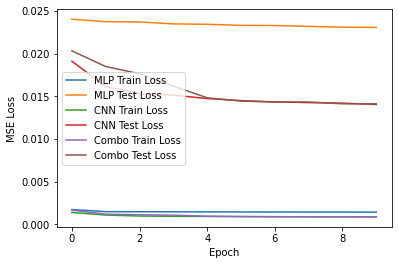

In [37]:
plt.plot(Train_MLP_Loss, label='MLP Train Loss')
plt.plot(Test_MLP_Loss, label='MLP Test Loss')
plt.plot(Train_CNN_Loss, label='CNN Train Loss')
plt.plot( Test_CNN_Loss, label='CNN Test Loss')
plt.plot(Train_Combo_Loss, label='Combo Train Loss')
plt.plot(Test_Combo_Loss, label='Combo Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

In [38]:
classes = trainset.classes

Original Images
Reconstructed Images


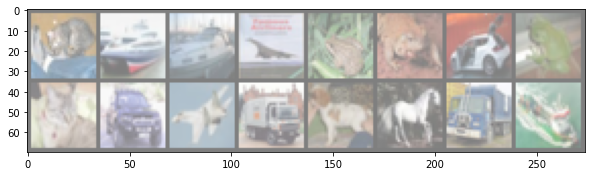

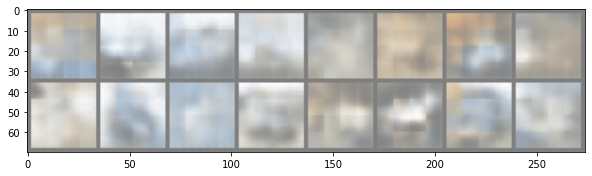

In [42]:
import matplotlib.pyplot as plt

Encoder_MLP = Encoder_MLP.to(device)

def imshow(img):
    img = img.cpu() 
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(testloader)
images, labels = next(dataiter)
images = images.to(device)

print('Original Images')
originalimg = torchvision.utils.make_grid(images)
# imshow(torchvision.utils.make_grid(images))
originalimg = originalimg.cpu() 
originalimg = originalimg / 2 + 0.5     
npimg = originalimg.numpy()
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():
    decoded_imgs = Encoder_CNN(images)

print('Reconstructed Images')
reconstructedimg = torchvision.utils.make_grid(decoded_imgs)
imshow(torchvision.utils.make_grid(decoded_imgs))

plt.show()

***MLP model:*** <br>
Time per Epoch: 47.1 seconds <br>
Model size: 3.08 MB <br>
Number of model parameters: 798,536

***CNN model:*** <br>
Time per Epoch: 41.1 seconds <br>
Model size: 0.23 MB <br>
Number of model parameters: 3,799 <br>

***CNN-MLP model:*** <br>
Time per Epoch: 39.4 seconds <br>
Model size: 0.24 MB <br>
Number of model parameters: 7,991 <br>


Although the CNN-MLP model exhibits slightly superior performance, it is not only its larger size, parameters, and longer computation time that should be taken into account. It is also important to note that during my experimentation with the models, there were several cases where the CNN-only model outperformed the combination model. Therefore, it appears that CNN is the preferable option.

### Step three: Let's play with Representation Sizes
Spoilers: You must have found CNN to be more effective.

Have you ever wondered how varying the size of a CNN auto-encoder's representation can affect its performance? If so, here's a challenge for you: Implement a CNN auto-encoder with different representation sizes and observe the impact on the reconstruction quality.

Play with the following representation sizes:
1. 10
2. 32
3. 100
4. 1000

When working with different representation sizes in a CNN auto-encoder, we may reach a point of diminishing returns where increasing the representation size does not lead to significant improvements in reconstruction quality. This can be due to factors such as increased model complexity and longer training times. Discuss where you feel we might reach this point of diminishing returns when working with CIFAR-10 dataset and varying representation sizes.

Do analysis as suggested earlier.

In [43]:
class CNNRepEncoder(nn.Module):
    def __init__(self, representation_size):

        super(CNNRepEncoder, self).__init__()

        self.representation_size = representation_size
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(4 * 4 * 4, representation_size))
        
        self.decoder = nn.Sequential(
            nn.Linear(representation_size, 64),
            nn.Unflatten(-1, (4, 4, 4)),
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid())


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [44]:
# code and analysis here
Encoder_CNN10 = CNNRepEncoder(10)
Encoder_CNN10.to(device)
cnnOptimizer10 = optim.Adam(Encoder_CNN10.parameters(), lr=0.001)

cnnrep10_TrainLoss, cnnrep10_TestLoss = train_and_test(Encoder_CNN10, cnnOptimizer10, 10)

Train loss: 0.0018459519477933646 and Test loss: 0.024623813539743425
Train loss: 0.0015002279092371463 and Test loss: 0.023664692866802214
Train loss: 0.0014657128767482936 and Test loss: 0.023346528889238834
Train loss: 0.0014539579598605633 and Test loss: 0.023248606054484845
Train loss: 0.001446635748744011 and Test loss: 0.023144364984333515
Train loss: 0.0014410892627574503 and Test loss: 0.023046589174866676
Train loss: 0.001435471388809383 and Test loss: 0.022938206619024275
Train loss: 0.001403692342042923 and Test loss: 0.022201239381730558
Train loss: 0.0013665653529390692 and Test loss: 0.02173405068963766
Train loss: 0.0013530622633732856 and Test loss: 0.02167937439531088


In [45]:
Encoder_CNN32 = CNNRepEncoder(32)
Encoder_CNN32.to(device)
cnnOptimizer32 = optim.Adam(Encoder_CNN32.parameters(), lr=0.001)

cnnrep32_TrainLoss, cnnrep32_TestLoss = train_and_test(Encoder_CNN32, cnnOptimizer32, 10)

Train loss: 0.001577623732853681 and Test loss: 0.019836068311333655
Train loss: 0.001133296472709626 and Test loss: 0.01685471969097853
Train loss: 0.0010206930854357778 and Test loss: 0.01575766385644674
Train loss: 0.0009687706810981036 and Test loss: 0.015253075516223907
Train loss: 0.0009386563784629107 and Test loss: 0.014825620077550412
Train loss: 0.0009213477071747184 and Test loss: 0.01465301196873188
Train loss: 0.0009108966853655874 and Test loss: 0.014495594137907028
Train loss: 0.0009042728149704635 and Test loss: 0.014348657588660716
Train loss: 0.0008985794608294964 and Test loss: 0.014425952735543252
Train loss: 0.0008938292438909411 and Test loss: 0.014352671626210213


In [68]:
# code and analysis here
cnnEncoder100 = CNNRepEncoder(100)
cnnEncoder100.to(device)
cnnOptimizer100 = optim.Adam(cnnEncoder100.parameters(), lr=0.001)

cnnrep100_TrainLoss, cnnrep100_TestLoss = train_and_test(cnnEncoder100, cnnOptimizer100, 10)

Train loss: 0.001456380426939577 and Test loss: 0.01885028503537178
Train loss: 0.0010799001572653652 and Test loss: 0.015214809434115887
Train loss: 0.0009183615870214999 and Test loss: 0.01428578037917614
Train loss: 0.0008791774734854698 and Test loss: 0.013882303796708583
Train loss: 0.0008590713601373136 and Test loss: 0.013540892300009728
Train loss: 0.0008451513501442968 and Test loss: 0.013292852051556111
Train loss: 0.0008343507738225162 and Test loss: 0.01320257861763239
Train loss: 0.0008270355945359916 and Test loss: 0.013209915427863598
Train loss: 0.0008214722301065922 and Test loss: 0.013093762038648128
Train loss: 0.0008165589686296881 and Test loss: 0.013093875625729562


In [47]:
# code and analysis here
Encoder_CNN1000 = CNNRepEncoder(1000)
Encoder_CNN1000.to(device)
cnnOptimizer1000 = optim.Adam(Encoder_CNN1000.parameters(), lr=0.001)

cnnrep1000_TrainLoss, cnnrep1000_TestLoss = train_and_test(Encoder_CNN1000, cnnOptimizer1000, 10)

Train loss: 0.0012364507298357785 and Test loss: 0.01498484165519476
Train loss: 0.0009020719372667373 and Test loss: 0.014085416576266288
Train loss: 0.0008581117301434279 and Test loss: 0.013593507789075374
Train loss: 0.0008379733696579933 and Test loss: 0.013262422017753125
Train loss: 0.000826830838881433 and Test loss: 0.013088669875264167
Train loss: 0.0008189946080558002 and Test loss: 0.012975333480536937
Train loss: 0.0008136074366793037 and Test loss: 0.013060815669596194
Train loss: 0.0008081823916547 and Test loss: 0.012812204138934613
Train loss: 0.0008038808446377515 and Test loss: 0.01281494429409504
Train loss: 0.000800418703109026 and Test loss: 0.012705662389099598


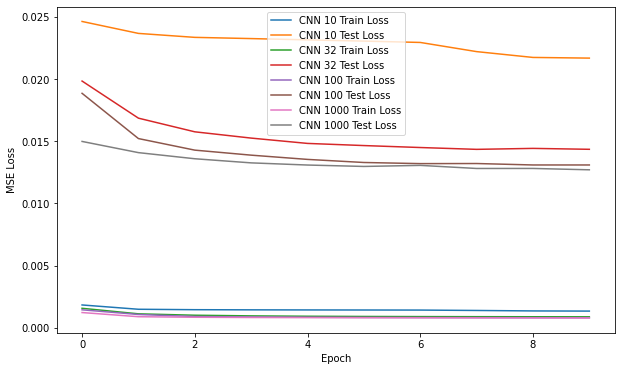

In [70]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(6)

plt.plot(cnnrep10_TrainLoss, label='CNN 10 Train Loss')
plt.plot(cnnrep10_TestLoss, label='CNN 10 Test Loss')
plt.plot(cnnrep32_TrainLoss, label='CNN 32 Train Loss')
plt.plot(cnnrep32_TestLoss, label='CNN 32 Test Loss')
plt.plot(cnnrep100_TrainLoss, label='CNN 100 Train Loss')
plt.plot(cnnrep100_TestLoss, label='CNN 100 Test Loss')
plt.plot(cnnrep1000_TrainLoss, label='CNN 1000 Train Loss')
plt.plot(cnnrep1000_TestLoss, label='CNN 1000 Test Loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

10 representations: <br>
Model Size: 0.47 MB
Parameters: 5,153
Epoch Time: 25.1 seconds

32 representations: <br>
Model Size: 0.48 MB
Parameters: 7,991
Epoch Time: 26.1 seconds

100 representations: <br>
Model Size: 0.52 MB
Parameters: 16,763
Epoch Time: 25.5 seconds

1000 representations: <br>
Model Size: 0.97 MB
Parameters: 132,863
Epoch Time: 25.5 seconds

We expected the outcome we're seeing. We notice a substantial improvement when we increase the number of representations from 10 to 32. As we continue to add more representations up to 100, the result is similar to 32 but slightly better. However, when we increase the representations to 1000, the number of parameters used by the model becomes too high. This doesn't help in reducing the test loss and may even lead to worse results due to overfitting, as can be seen above.
Therefore, the most suitable representation in this situation appears to be 100 as it exhibits the most progress, and incorporating more features doesn't significantly enhance performance.

Original Images
Reconstructed Images


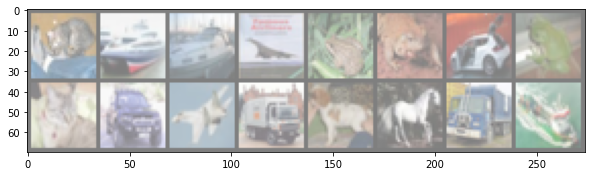

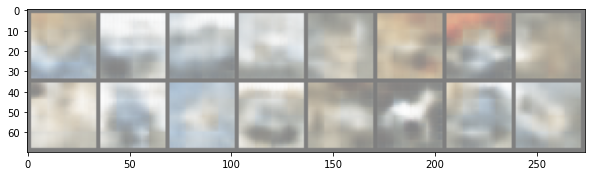

In [72]:
import matplotlib.pyplot as plt

dataiter = iter(testloader)
images, labels = next(dataiter)
images = images.to(device)

print('Original Images')
originalimg = torchvision.utils.make_grid(images)
originalimg = originalimg.cpu() 
originalimg = originalimg / 2 + 0.5     
orignpimg = originalimg.numpy()
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(orignpimg, (1, 2, 0)))

with torch.no_grad():
    decoded_imgs = cnnEncoder100(images)

print('Reconstructed Images')
reconstructedimg = torchvision.utils.make_grid(decoded_imgs)
reconstructedimg = reconstructedimg.cpu() 
reconstructedimg = reconstructedimg / 2 + 0.5     
reconstructedimg = reconstructedimg.numpy()
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(reconstructedimg, (1, 2, 0)))
# imshow(torchvision.utils.make_grid(decoded_imgs))

plt.show()

### Step four: What about the number of layers?

Experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder can have a significant impact on its performance with CIFAR-10 dataset. For our next challenge, let's explore how the number of layers can affect the quality of the reconstructed images. Would a deeper or shallower network be more effective for this task?

Play with the following numbers of layers for encoder and decoder each:
1. 1
2. 3
3. 5
4. 10

When experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder, we may reach a point of diminishing returns where adding more layers does not result in significant improvements in reconstruction quality. Additionally, deeper networks may be prone to overfitting, especially when training data is limited. Discuss where you feel we reach it. 

Do analysis as suggested earlier.

In [28]:
class CNN1(nn.Module):

    def __init__(self):
        super(CNN1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid())
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [29]:
from torchsummary import summary
CNN1Sum = CNN1()
summary(CNN1Sum, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 16, 16]          --
|    └─Conv2d: 2-1                       [-1, 16, 32, 32]          448
|    └─ReLU: 2-2                         [-1, 16, 32, 32]          --
|    └─MaxPool2d: 2-3                    [-1, 16, 16, 16]          --
├─Sequential: 1-2                        [-1, 3, 32, 32]           --
|    └─ConvTranspose2d: 2-4              [-1, 3, 32, 32]           435
|    └─Sigmoid: 2-5                      [-1, 3, 32, 32]           --
Total params: 883
Trainable params: 883
Non-trainable params: 0
Total mult-adds (M): 0.89
Input size (MB): 0.01
Forward/backward pass size (MB): 0.15
Params size (MB): 0.00
Estimated Total Size (MB): 0.16


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 16, 16]          --
|    └─Conv2d: 2-1                       [-1, 16, 32, 32]          448
|    └─ReLU: 2-2                         [-1, 16, 32, 32]          --
|    └─MaxPool2d: 2-3                    [-1, 16, 16, 16]          --
├─Sequential: 1-2                        [-1, 3, 32, 32]           --
|    └─ConvTranspose2d: 2-4              [-1, 3, 32, 32]           435
|    └─Sigmoid: 2-5                      [-1, 3, 32, 32]           --
Total params: 883
Trainable params: 883
Non-trainable params: 0
Total mult-adds (M): 0.89
Input size (MB): 0.01
Forward/backward pass size (MB): 0.15
Params size (MB): 0.00
Estimated Total Size (MB): 0.16

In [24]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [26]:
from torchsummary import summary
CNN3Sum = CNN3()
summary(CNN3Sum, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4, 4, 4]             --
|    └─Conv2d: 2-1                       [-1, 16, 32, 32]          448
|    └─ReLU: 2-2                         [-1, 16, 32, 32]          --
|    └─MaxPool2d: 2-3                    [-1, 16, 16, 16]          --
|    └─Conv2d: 2-4                       [-1, 8, 16, 16]           1,160
|    └─ReLU: 2-5                         [-1, 8, 16, 16]           --
|    └─MaxPool2d: 2-6                    [-1, 8, 8, 8]             --
|    └─Conv2d: 2-7                       [-1, 4, 8, 8]             292
|    └─ReLU: 2-8                         [-1, 4, 8, 8]             --
|    └─MaxPool2d: 2-9                    [-1, 4, 4, 4]             --
├─Sequential: 1-2                        [-1, 3, 32, 32]           --
|    └─ConvTranspose2d: 2-10             [-1, 8, 8, 8]             296
|    └─ReLU: 2-11                        [-1, 8, 8, 8]             --
|    └─Co

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4, 4, 4]             --
|    └─Conv2d: 2-1                       [-1, 16, 32, 32]          448
|    └─ReLU: 2-2                         [-1, 16, 32, 32]          --
|    └─MaxPool2d: 2-3                    [-1, 16, 16, 16]          --
|    └─Conv2d: 2-4                       [-1, 8, 16, 16]           1,160
|    └─ReLU: 2-5                         [-1, 8, 16, 16]           --
|    └─MaxPool2d: 2-6                    [-1, 8, 8, 8]             --
|    └─Conv2d: 2-7                       [-1, 4, 8, 8]             292
|    └─ReLU: 2-8                         [-1, 4, 8, 8]             --
|    └─MaxPool2d: 2-9                    [-1, 4, 4, 4]             --
├─Sequential: 1-2                        [-1, 3, 32, 32]           --
|    └─ConvTranspose2d: 2-10             [-1, 8, 8, 8]             296
|    └─ReLU: 2-11                        [-1, 8, 8, 8]             --
|    └─Co

In [22]:
class CNN5(nn.Module):
    def __init__(self):
        super(CNN5, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [23]:
from torchsummary import summary
CNN5Sum = CNN5()
summary(CNN5Sum, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 16, 16, 16]          448
|    └─ReLU: 2-2                         [-1, 16, 16, 16]          --
|    └─Conv2d: 2-3                       [-1, 32, 8, 8]            4,640
|    └─ReLU: 2-4                         [-1, 32, 8, 8]            --
|    └─Conv2d: 2-5                       [-1, 64, 4, 4]            18,496
|    └─ReLU: 2-6                         [-1, 64, 4, 4]            --
|    └─Conv2d: 2-7                       [-1, 128, 2, 2]           73,856
|    └─ReLU: 2-8                         [-1, 128, 2, 2]           --
|    └─Conv2d: 2-9                       [-1, 256, 1, 1]           295,168
|    └─ReLU: 2-10                        [-1, 256, 1, 1]           --
├─Sequential: 1-2                        [-1, 3, 32, 32]           --
|    └─ConvTranspose2d: 2-11             [-1, 128, 2, 2]           2

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 16, 16, 16]          448
|    └─ReLU: 2-2                         [-1, 16, 16, 16]          --
|    └─Conv2d: 2-3                       [-1, 32, 8, 8]            4,640
|    └─ReLU: 2-4                         [-1, 32, 8, 8]            --
|    └─Conv2d: 2-5                       [-1, 64, 4, 4]            18,496
|    └─ReLU: 2-6                         [-1, 64, 4, 4]            --
|    └─Conv2d: 2-7                       [-1, 128, 2, 2]           73,856
|    └─ReLU: 2-8                         [-1, 128, 2, 2]           --
|    └─Conv2d: 2-9                       [-1, 256, 1, 1]           295,168
|    └─ReLU: 2-10                        [-1, 256, 1, 1]           --
├─Sequential: 1-2                        [-1, 3, 32, 32]           --
|    └─ConvTranspose2d: 2-11             [-1, 128, 2, 2]           2

In [19]:

class CNN10(nn.Module):

    def __init__(self):
        super(CNN10, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [57]:
# code and analysis here
CNN1_encoder = CNN1()
CNN1_encoder.to(device)
cnnOpti1 = optim.Adam(CNN1_encoder.parameters(), lr=0.001)

cnn1_TrainLoss, cnn1_TestLoss = train_and_test(CNN1_encoder, cnnOpti1, 10)

Train loss: 0.0003475569497002289 and Test loss: 0.002117390483617783
Train loss: 0.0001199530875729397 and Test loss: 0.0017839951949194075
Train loss: 0.00010888532028300687 and Test loss: 0.0016817103784531355
Train loss: 0.0001043694550381042 and Test loss: 0.0016334435932338239
Train loss: 0.00010208831363124772 and Test loss: 0.001604771960526705
Train loss: 0.00010073666849173605 and Test loss: 0.001594885493069887
Train loss: 9.976761621888727e-05 and Test loss: 0.001581289474107325
Train loss: 9.895700974971988e-05 and Test loss: 0.0015754058942198754
Train loss: 9.839584797387942e-05 and Test loss: 0.0015851679930463432
Train loss: 9.786981901153922e-05 and Test loss: 0.00154765057079494


In [58]:
# code and analysis here
CNN3_encoder = CNN3()
CNN3_encoder.to(device)
cnnOpti3 = optim.Adam(CNN3_encoder.parameters(), lr=0.001)

cnn3_TrainLoss, cnn3_TestLoss = train_and_test(CNN3_encoder, cnnOpti3, 10)

Train loss: 0.0013685861439071596 and Test loss: 0.017959811517596246
Train loss: 0.0009764328730478883 and Test loss: 0.014724786600470543
Train loss: 0.0009045730884559452 and Test loss: 0.014289000345766543
Train loss: 0.0008854110410623252 and Test loss: 0.01410610556602478
Train loss: 0.0008732915617432445 and Test loss: 0.01384913174957037
Train loss: 0.0008647376876696944 and Test loss: 0.013756153179705143
Train loss: 0.0008581740068271756 and Test loss: 0.013643954832851886
Train loss: 0.0008495298465155065 and Test loss: 0.013479749201238156
Train loss: 0.0008414019465632737 and Test loss: 0.01338494450300932
Train loss: 0.0008358945387601852 and Test loss: 0.013470161201059818


In [59]:
# code and analysis here
CNN5_encoder = CNN5()
CNN5_encoder.to(device)
cnnOpti5 = optim.Adam(CNN5_encoder.parameters(), lr=0.001)

cnn5_TrainLoss, cnn5_TestLoss = train_and_test(CNN5_encoder, cnnOpti5, 10)

Train loss: 0.0013748450044170021 and Test loss: 0.014463166326284409
Train loss: 0.0008208064387366176 and Test loss: 0.011901183968782425
Train loss: 0.0006794666776992381 and Test loss: 0.010271662719547749
Train loss: 0.0006029568868782372 and Test loss: 0.009196868083626032
Train loss: 0.0005573762350343168 and Test loss: 0.008641944774985314
Train loss: 0.0005214250266831368 and Test loss: 0.00808917737007141
Train loss: 0.0004942684271838516 and Test loss: 0.007677157467603684
Train loss: 0.00047114139235578475 and Test loss: 0.007385018725693226
Train loss: 0.00045168507314287127 and Test loss: 0.00710550506412983
Train loss: 0.0004342042778432369 and Test loss: 0.006798619905859232


In [107]:
# code and analysis here
cnnEncode10 = CNN10()
cnnEncode10.to(device)
cnnOpti10 = optim.Adam(cnnEncode10.parameters(), lr=0.001)
cnn10_TrainLoss, cnn10_TestLoss = train_and_test(cnnEncode10, cnnOpti10, 10)

In [20]:
from torchsummary import summary
CNN10Sum = CNN10()
summary(CNN10Sum, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 32, 16, 16]          896
|    └─ReLU: 2-2                         [-1, 32, 16, 16]          --
|    └─Conv2d: 2-3                       [-1, 32, 8, 8]            9,248
|    └─ReLU: 2-4                         [-1, 32, 8, 8]            --
|    └─Conv2d: 2-5                       [-1, 64, 4, 4]            18,496
|    └─ReLU: 2-6                         [-1, 64, 4, 4]            --
|    └─Conv2d: 2-7                       [-1, 64, 2, 2]            36,928
|    └─ReLU: 2-8                         [-1, 64, 2, 2]            --
|    └─Conv2d: 2-9                       [-1, 128, 1, 1]           73,856
|    └─ReLU: 2-10                        [-1, 128, 1, 1]           --
|    └─Conv2d: 2-11                      [-1, 128, 1, 1]           147,584
|    └─ReLU: 2-12                        [-1, 128, 1, 1]        

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 32, 16, 16]          896
|    └─ReLU: 2-2                         [-1, 32, 16, 16]          --
|    └─Conv2d: 2-3                       [-1, 32, 8, 8]            9,248
|    └─ReLU: 2-4                         [-1, 32, 8, 8]            --
|    └─Conv2d: 2-5                       [-1, 64, 4, 4]            18,496
|    └─ReLU: 2-6                         [-1, 64, 4, 4]            --
|    └─Conv2d: 2-7                       [-1, 64, 2, 2]            36,928
|    └─ReLU: 2-8                         [-1, 64, 2, 2]            --
|    └─Conv2d: 2-9                       [-1, 128, 1, 1]           73,856
|    └─ReLU: 2-10                        [-1, 128, 1, 1]           --
|    └─Conv2d: 2-11                      [-1, 128, 1, 1]           147,584
|    └─ReLU: 2-12                        [-1, 128, 1, 1]        

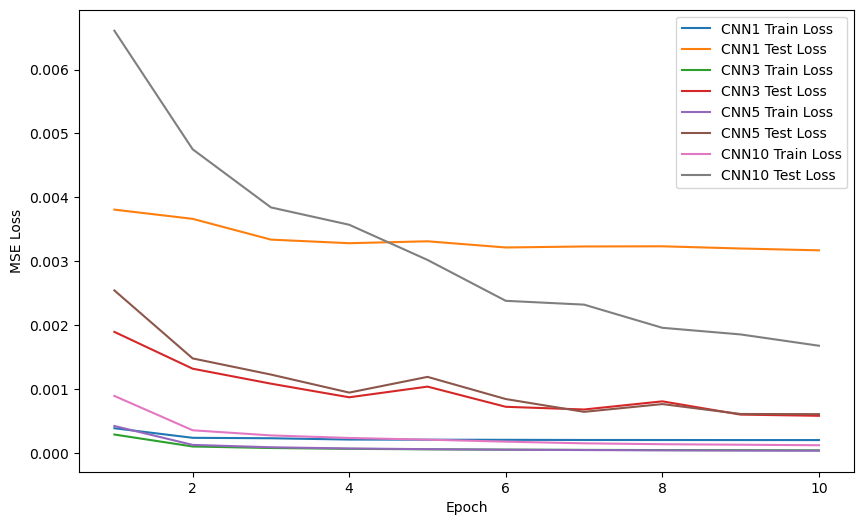

In [ ]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(6)

plt.plot(cnn1_TrainLoss, label='CNN1 Train Loss')
plt.plot(cnn1_TestLoss, label='CNN1 Test Loss')
plt.plot(cnn3_TrainLoss, label='CNN3 Train Loss')
plt.plot(cnn3_TestLoss, label='CNN3 Test Loss')
plt.plot(cnn5_TrainLoss, label='CNN5 Train Loss')
plt.plot(cnn5_TestLoss, label='CNN5 Test Loss')
plt.plot(cnn10_TrainLoss, label='CNN10 Train Loss')
plt.plot(cnn10_TestLoss, label='CNN10 Test Loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

Original Images
Reconstructed Images


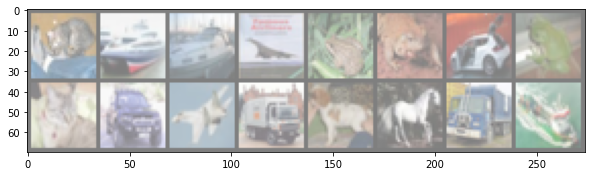

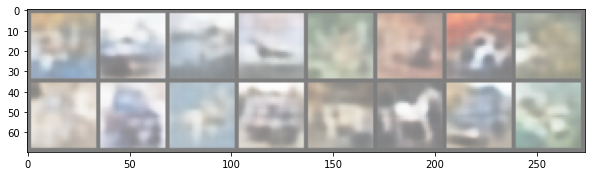

In [92]:
import matplotlib.pyplot as plt


dataiter = iter(testloader)
images, labels = next(dataiter)
images = images.to(device)

print('Original Images')

originalimg = torchvision.utils.make_grid(images)
originalimg = originalimg.cpu() 
originalimg = originalimg / 2 + 0.5     
noriginalimg = originalimg.numpy()
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(noriginalimg, (1, 2, 0)))

# imshow(torchvision.utils.make_grid(images))

with torch.no_grad():
    decoded_imgs = CNN5_encoder(images)

print('Reconstructed Images')

reconstructedimg = torchvision.utils.make_grid(decoded_imgs)
reconstructedimg = reconstructedimg.cpu() 
reconstructedimg = reconstructedimg / 2 + 0.5     
nreconstructedimg = reconstructedimg.numpy()
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(nreconstructedimg, (1, 2, 0)))

# imshow(torchvision.utils.make_grid(decoded_imgs))

plt.show()

***1 Layer:*** <br>
Params size (MB): 0.00 <br>
Model Size: 0.16 MB <br>
Parameters: 883 <br>
Epoch Time: 34.7 seconds <br>

***3 Layer:*** <br>
Params size (MB): 0.01 <br>
Model Size: 0.23 MB <br>
Parameters: 47,107 <br>
Epoch Time: 44.3 seconds <br>

***5 Layer:*** <br>
Model Size: 3.15 MB <br>
Parameters: 784,963 <br>
Params size (MB): 2.99 <br>
Epoch Time: 104.2 seconds <br>

***10 Layer:*** <br>
Model Size: 151.48 MB <br>
Parameters: 28,315,059 <br>
Params size (MB): 35.95 <br>
Epoch Time: 1038 seconds <br>
 

The model summary and plot clearly indicate that the model experiences notable overfitting when we exceed 5 layers. This is due to a sharp increase in the number of parameters as we add more layers, which is much more significant than when we only increase the representation. Consequently, the 10 layer model displays significant overfitting and also requires much more space than the other two models. The 3 layer model is in line with what we observed in the representation experiment with regards to the number of parameters, and it performs well. Therefore, it's probably best to choose between 3-5 layers.

### Explaination time!
Please write a short-essay explaining what AutoEncoder does, how it is different from other data-representation methods like PCA, t-SNE and Variational AutoEncoders. Also tell what were your take-outs from this experiment.

In [ ]:
# explainations here

Autoencoders are a type of neural network used in unsupervised learning, primarily to learn a compressed representation of input data such as images. Autoencoders typically have two parts: an encoder and a decoder. The encoder compresses the input data into a lower dimension, which can be used for various purposes. The decoder can then decompress it to retrieve the original output.

PCA is a linear dimensionality reduction technique that is ineffective for non-linear data. On the other hand, t-SNE can be used for non-linear dimensionality reduction, typically for data exploration and visualization. However, autoencoders, which are based on neural networks, tend to deliver superior results compared to these techniques.

Variational Autoencoders (VAEs) add a probabilistic layer to the encoder and decoder. They are designed to learn a continuous space, making them more flexible and suitable for a variety of data. Traditional encoders, like the ones used in this context, are discrete. Therefore, VAEs are useful for generative tasks, while traditional encoders are typically used for reconstruction tasks.


The assignment was quite helpful in learning about how CNNs are programmed and how they work, it was interesting to me that adding an extra layer can have drastic effects on the performance of the model. Also, while in the KNN experiment the results I got were not great, it is amazing that we can compress the images so much and still retain some distinct characterisitcs that can tell them apart. 

## Part 2: The return of kNN
Autoencoder representations can be useful for a wide range of machine learning tasks beyond just reconstructing input data. For example, the output of an encoder can be used as a feature representation for classification using k-Nearest Neighbors (kNN) or other classifiers. Similarly, the encoded representations can be used for unsupervised tasks like clustering, where the model groups similar images together based on their feature representation. This makes autoencoders a versatile tool for feature learning, with the potential to enhance the performance of a wide range of machine learning algorithms.

Since we have already trained auto-encoder on CIFAR-10, we will employ the encoder from the CNN model with representation size of $10$. Using a subset of CIFAR-10 train and test datasets, each with 10,000 and 1000 samples respectively, with an equal number of samples for each class, implement kNN classification using the encoder output as features. Share your findings and accuracy, F1 score and other relavant metrics on the test set. What insights can you draw from the results?

You are allowed to use sklearn or any other library for kNN and splitting dataset.

In [93]:
num_classes = 10

train_subset_indices = []
test_subset_indices = []
for i in range(num_classes):
    train_indices = np.where(np.array(trainset.targets) == i)[0]
    test_indices = np.where(np.array(testset.targets) == i)[0]
    train_subset_indices.extend(train_indices[:1000])
    test_subset_indices.extend(test_indices[:100])

trainsubset = torch.utils.data.Subset(trainset, train_subset_indices)
testsubset = torch.utils.data.Subset(testset, test_subset_indices)

trainsubsetloader = torch.utils.data.DataLoader(trainsubset, batch_size=16, shuffle=True, num_workers=2)
testsubsetloader = torch.utils.data.DataLoader(testsubset, batch_size=16, shuffle=False, num_workers=2)



In [94]:
from sklearn.neighbors import KNeighborsClassifier

encoder = Encoder_CNN1000.encoder
Encoder_CNN1000.to("cpu")

train_features = []
train_labels = []

with torch.no_grad():
    for images, labels in trainsubsetloader:
        features = encoder(images)
        features = features.view(features.size(0), -1)
        train_features.append(features)
        train_labels.append(labels)

train_features = torch.cat(train_features, dim=0)
train_labels = torch.cat(train_labels, dim=0)


test_features = []
test_labels = []

with torch.no_grad():
    for images, labels in testsubsetloader:
        features = encoder(images)
        features = features.view(features.size(0), -1)
        test_features.append(features)
        test_labels.append(labels)

test_features = torch.cat(test_features, dim=0)
test_labels = torch.cat(test_labels, dim=0)

train_features = train_features.cpu().numpy()
train_labels = train_labels.cpu().numpy()
test_features = test_features.cpu().numpy()
test_labels = test_labels.cpu().numpy()

k = 10
knn = KNeighborsClassifier(n_neighbors=k, metric="cosine", weights='distance')
knn.fit(train_features, train_labels)

accuracy = knn.score(test_features, test_labels)
print('Accuracy: %.2f%%' % (accuracy * 100))

Accuracy: 36.50%


Original Images
Reconstructed Images


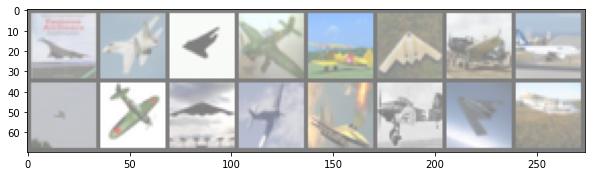

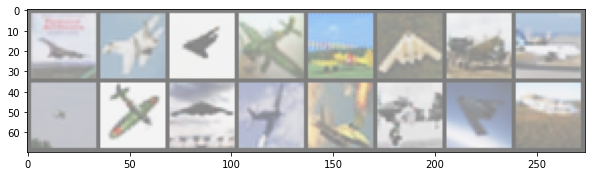

In [102]:
import matplotlib.pyplot as plt


def imshow(img):
    img = img.cpu() 
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(testsubsetloader)
images, labels = next(dataiter)

print('Original Images')
originalimg = torchvision.utils.make_grid(images)
originalimg = originalimg.cpu() 
originalimg = originalimg / 2 + 0.5     
noriginalimg = originalimg.numpy()
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(noriginalimg, (1, 2, 0)))

with torch.no_grad():
    decoded_imgs = CNN1_encoder(images)

print('Reconstructed Images')
decodedimg = torchvision.utils.make_grid(decoded_imgs)
decodedimg = decodedimg.cpu() 
decodedimg = decodedimg / 2 + 0.5     
ndecodedimg = decodedimg.numpy()
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(ndecodedimg, (1, 2, 0)))

plt.show()

## Part 3: Siamese Network (not part of assignment)
Siamese networks are useful for comparing and finding similarities between two inputs. The inputs from identical encoder sub-networks will be given as an input to a dense network (an MLP) and the prediction will be given as output of a Sigmoid function.

Employ the encoder from the best model to be used as the two-identical sub-networks of the Siamese Network. So, copy the weights from the best encoder to the two-identical sub-networks, set the learning rate of this encoder to be lower by a couple of order than that of the dense network.

Who knows, this might be part of next assignment during hectic times. (wink wink)
(Don't quote me on this though)

### Step one: Define a Siamese Network

In [96]:
# sample.
class SiameseNetwork(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder1 = encoder
        self.encoder2 = encoder
        self.decoder = nn.Sequential(
            nn.Linear(2048,1024),
        )

    def forward(self, x1, x2):
        encoded1 = self.encoder1(x1)
        encoded2 = self.encoder2(x2)
        return (encoded1,encoded2)
        
    def differentiate(self, x1_embedding, x2_embedding):
        x = torch.cat([x1_embedding,x2_embedding],dim=1)
        return self.decoder(x)


### Step two: Define the following three losses:
1. TripletLoss
2. ContrastiveLoss
3. Regularized Cross Entropy Loss

In [97]:
# TripletLoss defined as an example
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Compute the distances between the anchor, positive, and negative examples
        distance_pos = F.pairwise_distance(anchor, positive, p=2)
        distance_neg = F.pairwise_distance(anchor, negative, p=2)
        # Compute the triplet loss using the margin
        loss_triplet = torch.mean(torch.clamp(distance_pos - distance_neg + self.margin, min=0.0))
        return loss_triplet

In [98]:
# code here

### Train the Siamese network...
... and write a function that takes 2 inputs and outputs whether they belong to the same class or not. Plot and share the results of the function. The results should contain both successful results, i.e. classification as 'same' for inputs belonging to the same class and classification as 'not-same' for inputs belonging to different classes, as well as some unsuccessful results (that gives the wrong output than expected).
Provide an explanation of why the unsuccessful results might occur.

In [99]:
# code and analysis here

### And again. What did we learn?
Discuss any and all learnings here. The discussions must be all-encompassing so that we know what did you learn. 

To re-iterate: "Please do not copy from your friend or copy-paste from the internet. We can see repetitions during evaluations."